<img src="HH_single_neuron.png">

In [105]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
writer = tf.summary.FileWriter('./')

In [106]:
num_iterations = 1000
num_neurons = 2

In [107]:
def fIs(v, vi):
    #Todo
    return

In [108]:
G_K = tf.constant(18.)
E_K = tf.constant(-80.)
G_Na = tf.constant(45.)
E_Na = tf.constant(55.)
Phi = tf.constant(4.)

def fINaK(v, h, n):    
    Alpha1 = -0.1*(v+33)/(tf.exp(-0.1*(v+33)) - 1)
    Beta1 = 4*(tf.exp(-1*(v +58)/12))
    m_inf = Alpha1/(Alpha1 + Beta1)
    
    Alpha2 = 0.07*tf.exp(-1*(v+50)/10)
    Beta2 = 1/(tf.exp(-0.1*(v+20)) + 1)
    tau_h = 1/(Alpha2 + Beta2)
    h_inf = Alpha2/(Alpha2 + Beta2)
    
    Alpha3 = -0.01*(v+34)/(tf.exp(-0.1*(v+34)) - 1);
    Beta3 = 0.125*tf.exp(-1*(v+44)/25);
    tau_n = 1/(Alpha3 + Beta3);
    n_inf = Alpha3/(Alpha3 + Beta3);

    fn = Phi*(n_inf - n)/tau_n
    fh = Phi*(h_inf - h)/tau_h
    
    INa = G_Na*m_inf*m_inf*m_inf*h*(v - E_Na);
    Ik = G_K*n*n*n*n*(v - E_K);
    
    return INa, Ik, fn, fh

In [109]:
ve = tf.constant(-60.)
c = tf.constant(0.1)

def fIl(v):
    return tf.multiply(c, tf.subtract(ve,v))

In [115]:
h_cons = tf.constant(0.01)
h_by_two_cons = tf.constant(0.005)
one_by_six_cons = tf.constant(tf.divide(1, 6))
two_cons = tf.constant(2.)

def call_currents(v, n, h, t, step_input):    
    INa, Ik, dn, dh = fINaK(v, n, h)
    
    Il = fIl(v)
    
    dv = INa + Ik + Il #+ step_input
    
    return [dv, dn, dh]

def neuron_combined_steps(prev_state, step_input):
    v, n, h, t = prev_state
      
    v_1, n_1, h_1 = call_currents(v, n, h, t, step_input)
    
    v_2_in = tf.add(tf.multiply(h_by_two_cons, v_1), v)
    n_2_in = tf.add(tf.multiply(h_by_two_cons, n_1), n)
    h_2_in = tf.add(tf.multiply(h_by_two_cons, h_1), h)
    t_2_in = tf.add(t, h_by_two_cons)
    v_2, n_2, h_2 = call_currents(v_2_in, n_2_in, h_2_in, t_2_in, step_input)

    v_3_in = tf.add(tf.multiply(h_by_two_cons, v_2), v)
    n_3_in = tf.add(tf.multiply(h_by_two_cons, n_2), n)
    h_3_in = tf.add(tf.multiply(h_by_two_cons, h_2), h)
    t_3_in = tf.add(t, h_by_two_cons)
    v_3, n_3, h_3 = call_currents(v_3_in, n_3_in, h_3_in, t_3_in, step_input)

    v_4_in = tf.add(tf.multiply(h, v_2), v)
    n_4_in = tf.add(tf.multiply(h, n_2), n)
    h_4_in = tf.add(tf.multiply(h, h_2), h)
    t_4_in = tf.add(t, h_cons)
    v_4, n_4, h_4 = call_currents(v_4_in, n_4_in, h_4_in, t_4_in, step_input)

      
    v_next = tf.add(tf.multiply(one_by_six_cons, tf.add_n([v_1, tf.multiply(two_cons, v_2),
                                                           tf.multiply(two_cons, v_3), v_4])), v)
    n_next = tf.add(tf.multiply(one_by_six_cons, tf.add_n([n_1, tf.multiply(two_cons, n_2),
                                                           tf.multiply(two_cons, n_3), n_4])), n)
    h_next = tf.add(tf.multiply(one_by_six_cons, tf.add_n([h_1, tf.multiply(two_cons, h_2),
                                                           tf.multiply(two_cons, h_3), h_4])), h)
    
    return [v_next, n_next, h_next, t+1]

In [116]:
# inputs to the neurons
inp = 0.05
inputs = tf.Variable(np.array([[inp] + [0.]*(num_neurons-1)] * num_iterations), dtype=tf.float32)

# initial activations and the combined input from synaptic connections
v_initial = tf.Variable(np.array([-40.]*num_neurons), dtype=tf.float32)
n_initial = tf.Variable(np.array([-40.]*num_neurons), dtype=tf.float32)
h_initial = tf.Variable(np.array([-40.]*num_neurons), dtype=tf.float32)
t = tf.constant(0.)

initial_state = [v_initial, n_initial, h_initial, t]

# recurrent execution. will iterate to the size of the inputs
out = tf.scan(neuron_combined_steps, inputs, initializer=initial_state)

In [117]:
%%time
# running the tensorflow graph
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    writer.add_graph(sess.graph)
    iteration_vals = sess.run(out)

CPU times: user 8.7 s, sys: 1.55 s, total: 10.2 s
Wall time: 8.8 s


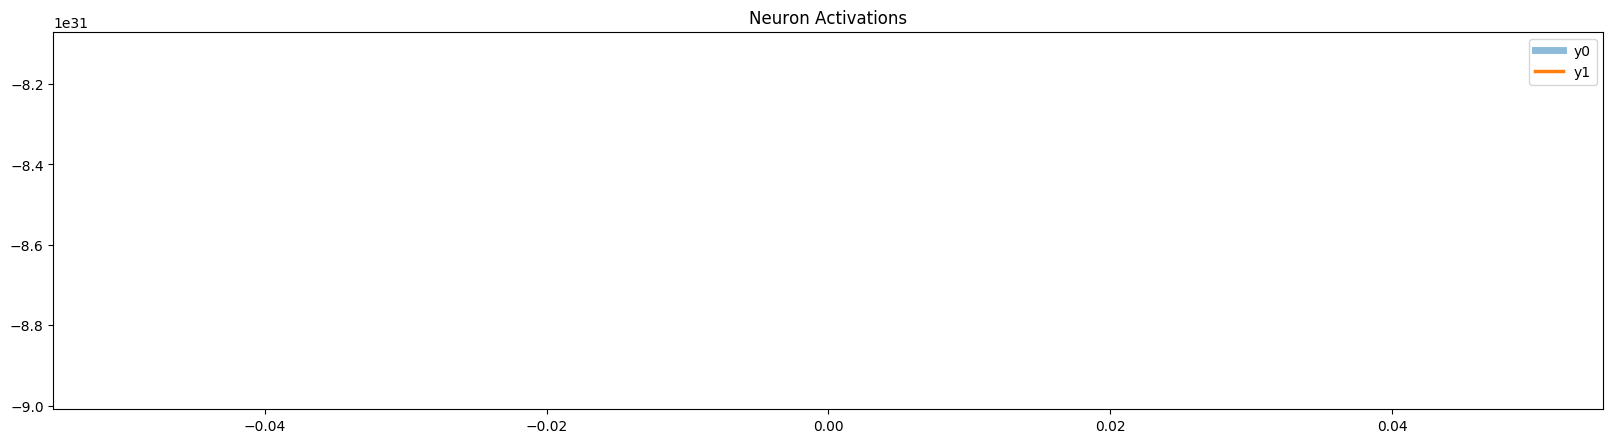

In [118]:
plt.figure(figsize=(20,5))
plt.title('Neuron Activations')
for i in range(num_neurons):
    plt.plot([y[i] for y in iteration_vals[0]], label='y'+str(i), alpha=(i+1.0)/(num_neurons),
             linewidth=5*(num_neurons-i)/(num_neurons))
plt.legend()
plt.show()

In [119]:
iteration_vals[0][0:25]

array([[ -8.53944579e+31,  -8.53944579e+31],
       [             nan,              nan],
       [             nan,              nan],
       [             nan,              nan],
       [             nan,              nan],
       [             nan,              nan],
       [             nan,              nan],
       [             nan,              nan],
       [             nan,              nan],
       [             nan,              nan],
       [             nan,              nan],
       [             nan,              nan],
       [             nan,              nan],
       [             nan,              nan],
       [             nan,              nan],
       [             nan,              nan],
       [             nan,              nan],
       [             nan,              nan],
       [             nan,              nan],
       [             nan,              nan],
       [             nan,              nan],
       [             nan,              nan],
       [  